# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy
import pandas as pd
from __future__ import division

In [2]:
PATH_TO_DATA = "data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        
        self.load_wordvec(fname, nmax)        
        self.id2word = pd.Series(self.word2vec.keys()).to_dict()
        self.word2id= {v: k for k, v in self.id2word.items()}
        self.embeddings = np.array(self.word2vec.values())
        
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort                 
        scores= map(lambda i: self.score(w,i), self.id2word.values())
        best_idx= np.argsort(scores)[::-1][1:K+1]
        similars = map(lambda i: self.id2word.get(i), best_idx) 
        return similars
    
    
    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        #Option 1
       # w1= self.word2id.get(w1)
       # w2= self.word2id.get(w2)
       # cosine_similarity = np.dot(self.embeddings[w1], self.embeddings[w2])/(np.linalg.norm(self.embeddings[w1])* np.linalg.norm(self.embeddings[w2]))
        
        #Option 2
        cosine_similarity = np.dot(self.word2vec[w1], self.word2vec[w2])/(np.linalg.norm(self.word2vec[w1])* np.linalg.norm(self.word2vec[w2]))
        return  (cosine_similarity)

In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)
print('\n')

#Paris and Germany don't exist 

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs','man','cat'), ('dog', 'pet', 'cats','woman','chair')):
    print(w1, w2, w2v.score(w1, w2))
print('\n')    
for w1 in ['cat', 'dog', 'dogs','women']:
    print(w2v.most_similar(w1))

Loaded 25000 pretrained word vectors


('cat', 'dog', 0.671683666279249)
('dog', 'pet', 0.684206402966922)
('dogs', 'cats', 0.7074389328052403)
('man', 'woman', 0.7459396036070456)
('cat', 'chair', 0.19644081612667258)


[u'cats', u'kitty', u'kitten', u'Cat', u'dog']
[u'dogs', u'puppy', u'Dog', u'canine', u'pup']
[u'dog', u'Dogs', u'puppies', u'cats', u'canine']
[u'men', u'Women', u'woman', u'ladies', u'Men']


In [5]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings        
        # take a sentence , split it to words , for each word take the weighted 
        # AVG of the word embedding idf
        sentemb=[]       
        for sent in sentences:
            #words = sent.split(' ')
            vecs= []           
            for word in sent: 
                if word not in self.w2v.word2vec: 
                        vecs.append(np.zeros(300))
                        continue
                w_vec= self.w2v.word2vec[word]
                if idf is False:
                    vecs.append(w_vec)
                else: 
                    if word in self.idf : 
                        vecs.append(w_vec * self.idf[word])
                    else: 
                        vecs.append(w_vec)
            sent_vec = np.mean(np.array(vecs), axis=0)
            sentemb.append(sent_vec)                           
        return np.vstack(sentemb)  

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them 
        # compute the knn between sentences after removing the same sentences l
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)        
        scores = [np.dot(query, sent.T) / (np.linalg.norm(query) *np.linalg.norm(sent)) for sent in keys  ] 
        scores = map(lambda i: scores[i][0],range(len(scores)))       
        scores = np.array([0 if np.isnan(score) else score for score in scores])
        idxs = scores.argsort()[::-1][1:K+1]
    
        print('\n\nTop-%s NNs of \n"%s"\n\n' % (K, ' '.join(s)))
        for i, idx in enumerate(idxs):
             print('%s) %s , score:%s'  % (i + 1, ' '.join(sentences[idx]) , np.round(scores [idx],3)))

      
    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        sent_emb1= self.encode([s1], idf)
        sent_emb2=  self.encode([s2], idf)
        if ( (sent_emb1 !=np.zeros(300)).all() & (sent_emb2 !=np.zeros(300)).all()):
            cosine_similarity = np.dot(sent_emb1, sent_emb2.T)/(np.linalg.norm(sent_emb1)* np.linalg.norm(sent_emb2))
            return (cosine_similarity[0,0])
        else: 
            return (0)
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}        
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1                
        self.idf= {k: max(1, np.log10(len(sentences) / (v)))  for k, v in idf.items()}

In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"  from previous lab
sentences = []
with open('data/sentences.txt') as f:
    for i, line in enumerate(f):
        sent = line.rstrip().split()
        sentences.append(sent)
print('Found %s sentences' % len(sentences))

# Build idf scores for each word
#idf = {} if True else s2v.build_idf(sentences)

print("\nBoV-mean:")
print ("--------------")
# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
sent1= '' if not sentences else ' '.join(sentences[7])
sent2= '' if not sentences else' '.join(sentences[13])
print("\nThe Score between : \n -%s  \n -%s \n is %s"% (sent1 , sent2, s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13])))

print("\nBoV-idf:")
print ("--------------")
idf = True 
s2v.build_idf(sentences)
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print("\nThe Score between : \n -%s  \n -%s \n is %s"% (sent1 , sent2, s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf)))

Loaded 200000 pretrained word vectors
Found 150736 sentences

BoV-mean:
--------------


Top-5 NNs of 
"1 smiling african american boy ."


1) an african american man smiling . , score:0.917
2) a little african american boy and girl looking up . , score:0.85
3) an afican american woman standing behind two small african american children . , score:0.822
4) an african american man is sitting . , score:0.821
5) a girl in black hat holding an african american baby . , score:0.819

The Score between : 
 -1 man singing and 1 man playing a saxophone in a concert .  
 -10 people venture out to go crosscountry skiing . 
 is 0.5726258859719605

BoV-idf:
--------------


Top-5 NNs of 
"1 smiling african american boy ."


1) an african american man smiling . , score:0.922
2) an african american man is sitting . , score:0.871
3) a little african american boy and girl looking up . , score:0.865
4) an afican american woman standing behind two small african american children . , score:0.855
5) a girl 

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
def load_dic(path, language, max_size):
    my_dict = {}
    with open(path) as f:
        for i, line in enumerate(f):
            if ((i >0) & (i<max_size+1)) : #We skip the first line that contains the dimensions of the file 
                items = line.rstrip().split()
                word = items[0]
                vect = np.array([float(i) for i in items[1:]])
                my_dict[word] = vect
                
    id2word = pd.Series(my_dict.keys()).to_dict()
    word2id= {v: k for k, v in id2word.items()}
    embeddings = np.array(my_dict.values())
    
    print('Found %s %s words' % (len(my_dict.keys()), language))
    return (my_dict,id2word,word2id, embeddings )

dict_en, id2word_en ,word2id_en, embeddings_en  = load_dic(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), 'english', 50000)
dict_fr, id2word_fr ,word2id_fr, embeddings_fr  = load_dic(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), 'french', 50000)

Found 50000 english words
Found 50000 french words


In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE

bilingual_dictionary = set(dict_en).intersection(set(dict_fr))
X=[]      #French words
Y=[]      #English words
word2id_translation={}       #To save the position of the word in the matrices

for word in bilingual_dictionary:
    X.append(dict_fr[word] )   
    Y.append(dict_en[word])
    word2id_translation[word]=len(word2id_translation)

id2word_translation= {v: k for k, v in word2id_translation.items()}
X = np.array(X)
Y = np.array(Y)

print('Among the common words : \n%s' %(list(bilingual_dictionary)[:20]))

Among the common words : 
['writings', 'schlegel', 'hordes', 'both', 'galactica', 'sonja', 'four', '\xc3\xa9t\xc3\xa9', 'woods', 'spiders', 'francesco', 'francesca', 'gabriella', 'gabrielle', 'sevens', 'grenier', 'wie\xc5\x9b', 'pardon', 'sprague', 'rika']


Find optimal W of orthogonality contraints 

In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector


# TYPE CODE HERE
from scipy import linalg


################# In the common words only #################
# W * French_vector => English_vector
# W^T * English_vector => French_vector

# perform the SVD
product = np.dot( Y, X.transpose())
U, s, V_t = np.linalg.svd(product)

# return orthogonal transformation which aligns source language to the target
W= np.matmul(U, V_t)
X_projetcted=np.matmul(W, X)
Y_projetcted=np.matmul(W.transpose(), Y)

################## In the whole dictionnary #################
print ('Another way to formalize the orthogonal procrustes problem is the following:')
print ('\n W* = argmin || X.W - Y || has a closed form solution: W = U.V^T  where  U.Sig.V^T = SVD(X^T.Y)')
print ('\nThis projection obtained by the second version allows us to project the whole source dictionary (french) and not just the common words')

# perform the SVD
product = np.dot( X.transpose(), Y)
U, s, V_t = np.linalg.svd(product)

# return orthogonal transformation which aligns source language to the target
W_whole_dic= np.matmul(U, V_t)
W_whole_dic_transp= W_whole_dic.transpose()

dict_fr_projected= {k: np.matmul(v,W_whole_dic) for k, v in dict_fr.items()}
dict_en_projected= {k: np.matmul(v,W_whole_dic_transp) for k, v in dict_en.items()}

Another way to formalize the orthogonal procrustes problem is the following:

 W* = argmin || X.W - Y || has a closed form solution: W = U.V^T  where  U.Sig.V^T = SVD(X^T.Y)

This projection obtained by the second version allows us to project the whole source dictionary (french) and not just the common words


In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

#Take a french word, apply W and apply knn, should get the translation

# TYPE CODE HERE

print('##########################################################################################')
print('######                         1. French to English                                 ######')
print('##########################################################################################')

french_word= 'suicide'
K = 10

# a . In the common words 
id_french_word= word2id_translation[french_word]
keys =  Y
query = X_projetcted[id_french_word]        
scores = np.array([np.dot(query, sent.T) / (np.linalg.norm(query) *np.linalg.norm(sent)) for sent in keys  ] )
idxs = scores.argsort()[::-1][1:K+1]

print('\nTop-%s NNs english words that correnspond to the french word \n"%s"\n' % (K, french_word))
print('a.In the common words:\n')
for i, idx in enumerate(idxs):
    print('%s) %s , score:%s'  % (i + 1, id2word_translation[idx] , np.round(scores [idx],3)))
    

# b. In the whole dictionnary
keys =  embeddings_en
query = dict_fr_projected[french_word]        
scores = np.array([np.dot(query, sent.T) / (np.linalg.norm(query) *np.linalg.norm(sent)) for sent in keys  ] )
idxs = scores.argsort()[::-1][1:K+1]
print('\nb.In the whole english dictionnary:\n')
for i, idx in enumerate(idxs):
    print('%s) %s , score:%s'  % (i + 1, id2word_en[idx] , np.round(scores [idx],3)))



print('\n')
print('##########################################################################################')
print('######                         2. English to French                                 ######')
print('##########################################################################################')

english_word= 'suicide'
K = 10

# a . In the common words 
id_english_word= word2id_translation[english_word]
keys =  X
query = Y_projetcted[id_english_word]        
scores = np.array([np.dot(query, sent.T) / (np.linalg.norm(query) *np.linalg.norm(sent)) for sent in keys  ] )
idxs = scores.argsort()[::-1][1:K+1]

print('\nTop-%s NNs french words that correnspond to the english word \n"%s"\n' % (K, english_word))
print('a.In the common words:\n')
for i, idx in enumerate(idxs):
    print('%s) %s , score:%s'  % (i + 1, id2word_translation[idx] , np.round(scores [idx],3)))
    

# b. In the whole dictionnary
keys =  embeddings_fr
query = dict_en_projected[english_word]        
scores = np.array([np.dot(query, sent.T) / (np.linalg.norm(query) *np.linalg.norm(sent)) for sent in keys  ] )
idxs = scores.argsort()[::-1][1:K+1]
print('\nb.In the whole french dictionnary:\n')
for i, idx in enumerate(idxs):
    print('%s) %s , score:%s'  % (i + 1, id2word_fr[idx] , np.round(scores [idx],3)))


##########################################################################################
######                         1. French to English                                 ######
##########################################################################################

Top-10 NNs english words that correnspond to the french word 
"suicide"

a.In the common words:

1) suicides , score:0.545
2) killing , score:0.381
3) murder , score:0.353
4) homicide , score:0.333
5) overdose , score:0.33
6) bomb , score:0.327
7) murders , score:0.319
8) killed , score:0.312
9) death , score:0.311
10) homicides , score:0.302

b.In the whole english dictionnary:

1) suicidal , score:0.569
2) overdose , score:0.554
3) perpetrator , score:0.527
4) assassination , score:0.524
5) suicides , score:0.518
6) assailant , score:0.498
7) stabbing , score:0.495
8) gunshot , score:0.491
9) murder , score:0.489
10) death , score:0.489


#############################################################################

If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [11]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
from nltk.tokenize import word_tokenize

def load_sst():
    sst = {'train': {'S': [], 'X': [], 'X_idf':[], 'y': []},
            'dev': {'S': [], 'X': [], 'X_idf':[], 'y': []},
            'test.X': {'S': [], 'X': [], 'X_idf':[], 'y': []}}
    for split in ['train', 'dev', 'test.X']:
        with open('data/SST/stsa.fine.%s' % split) as f:
            for line in f:
                
                if (split !='test.X') :
                    y, sent = line.rstrip().split(' ', 1)
                    y=int(y)
                    assert y in range(0,6)
                    sent = word_tokenize(sent.decode('utf-8'))
                    sst[split]['y'].append(y)
                    sst[split]['S'].append(sent)
                    assert len(sst[split]['y']) == len(sst[split]['S'])             
                else: 
                    sent = line.rstrip()
                    sent = word_tokenize(sent.decode('utf-8'))
                    sst[split]['S'].append(sent)            
            print('Loaded %s %s SST samples' % (len(sst[split]['S']), split.upper()))
    return sst
sst = load_sst()

print('\n\nREVIEW: \n%s\n' % sst['train']['S'][0])
print('LABEL: %s' % sst['train']['y'][0])

Loaded 8544 TRAIN SST samples
Loaded 1101 DEV SST samples
Loaded 2210 TEST.X SST samples


REVIEW: 
[u'a', u'stirring', u',', u'funny', u'and', u'finally', u'transporting', u're-imagining', u'of', u'beauty', u'and', u'the', u'beast', u'and', u'1930s', u'horror', u'films']

LABEL: 4


In [12]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

s2v.build_idf(sst["train"]['S'])


for split in ['train', 'dev', 'test.X']:
    sst[split]['X'] = s2v.encode(sst[split]['S'])
    sst[split]['X_idf'] = s2v.encode(sst[split]['S'], True)

print('\nTrain:')
print(sst['train']['X'].shape)
print(sst['train']['X_idf'].shape)

print('\nDev:')
print(sst['dev']['X'].shape)
print(sst['dev']['X_idf'].shape)

print('\nTest:')
print(sst['test.X']['X'].shape)
print(sst['test.X']['X_idf'].shape)

Loaded 200000 pretrained word vectors

Train:
(8544, 300)
(8544, 300)

Dev:
(1101, 300)
(1101, 300)

Test:
(2210, 300)
(2210, 300)


In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE
from sklearn.linear_model import LogisticRegression
logit=LogisticRegression()

X_train = sst['train']['X']
X_train_idf = sst['train']['X_idf']
y_train = sst['train']['y']

X_valid = sst['dev']['X']
X_valid_idf = sst['dev']['X_idf']
y_valid = sst['dev']['y']

X_test = sst['test.X']['X']
X_test_idf = sst['test.X']['X_idf']
y_test = sst['test.X']['y']


#####1. Without idf
print("\nBoV-mean (average of word vectors):")
print ("------------------------------------")
best_score= 0
best_C=0
best_clf = LogisticRegression()
#Select best L2-regularization wrt valid accuracy
for reg in [2**t for t in range(-2, 4, 1)] : 
    clf = LogisticRegression(C=reg, random_state=1234)
    clf.fit(X_train, y_train)
    score=clf.score(X_valid, y_valid)    
    if (score > best_score) : 
        best_score=score
        best_C=reg
        best_clf = clf  
score_train = best_clf.score(X_train, y_train)
print ("Accuracy of the training set: %s"%np.round(score_train,2))
print ("Accuracy of the dev set: %s"%np.round(best_score,2))
print ("Best C: %s"%best_C)


    
####2. With idf
print("\n\nBoV-idf (weighted-average of word vectors):")
print ("--------------------------------------------")
       
best_score_idf= 0
best_C_idf=0
best_clf_idf = LogisticRegression()
for reg in [2**t for t in range(-2, 4, 1)] : 
    clf = LogisticRegression(C=reg, random_state=1234)
    clf.fit(X_train_idf, y_train)
    score=clf.score(X_valid_idf, y_valid)  
    if (score > best_C_idf) : 
        best_score_idf=score
        best_C_idf=reg
        best_clf_idf = clf  
score_train_idf = best_clf_idf.score(X_train_idf, y_train)
print ("Accuracy of the training set: %s"%np.round(score_train_idf,2))
print ("Accuracy of the dev set: %s"% np.round(best_score_idf,2))
print ("Best C Idf:%s"%best_C_idf)


BoV-mean (average of word vectors):
------------------------------------
Accuracy of the training set: 0.49
Accuracy of the dev set: 0.44
Best C: 1


BoV-idf (weighted-average of word vectors):
--------------------------------------------
Accuracy of the training set: 0.49
Accuracy of the dev set: 0.42
Best C Idf:0.5


In [53]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
y_test= best_clf.predict(X_test)
assert len(y_test)==2210
np.savetxt('logreg_bov_y_test_sst.txt', y_test, fmt='%s')   

In [16]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE
import time as t

from sklearn.linear_model import LogisticRegression , LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier ,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV


def test_classifier(X_train, y_train, X_test, y_test, classifier):
    classifier_name = str(type(classifier).__name__)
    print("\n\nTesting " + classifier_name)
    print("===================================")
    now = t.time()
    list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    print("Learing time {0}s".format(t.time() - now))
    now = t.time()
    predictions = model.predict(X_test)
    print("Predicting time {0}s".format(t.time() - now))
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy " + str(accuracy))
    return model,predictions

def score_cv(model, X, y, scoring='accuracy'):
    s = cross_val_score(model, X, y, cv = 5, scoring=scoring)
    return np.mean(s)

def optimize_rf(X_train,y_train):
    K = 9
    rf=RandomForestClassifier()

    ##### n_estimators
    #Range of parameters
    param=[{"n_estimators":[10,50,100,500]}]
    rForest2= GridSearchCV(RandomForestClassifier(random_state=1),
            param,cv=K,n_jobs=-1)
    rForestOpt=rForest2.fit(X_train,y_train)
    # Optimal parameter
    n_est=rForestOpt.best_params_['n_estimators']
    print ('n_estimators : ',n_est)

    #max_features represents the maximum number of features that will be used in the model
    #Range of parameters
    param=[{"max_features":["auto","sqrt","log2"]}]
    rForest2= GridSearchCV(RandomForestClassifier(n_estimators=n_est,random_state=1),
            param,cv=K,n_jobs=-1)
    rForestOpt=rForest2.fit(X_train,y_train)

    # Optimal parameter
    max_f=rForestOpt.best_params_['max_features']
    print ('max_feature : ', max_f)

    #Range of parameters
    param=[{"min_samples_leaf":[3,5,7,10]}]
    rForest2= GridSearchCV(RandomForestClassifier(n_estimators=n_est,max_features=max_f,random_state=1),
            param,cv=K,n_jobs=-1)
    rForestOpt=rForest2.fit(X_train,y_train)
    # Optimal parameter
    min_sl=rForestOpt.best_params_['min_samples_leaf']
    print ('min_samples_leaf : ', min_sl)


    #Range of parameters
    param=[{"min_samples_split":[5,7,10,15]}]
    rForest2= GridSearchCV(RandomForestClassifier(n_estimators=n_est,max_features=max_f,min_samples_leaf=min_sl,
                                                  random_state=1),
                           param,cv=K,n_jobs=-1)
    rForestOpt=rForest2.fit(X_train,y_train)
    # Optimal parameter
    min_ss=rForestOpt.best_params_['min_samples_split']
    print ('min_samples_split : ', min_ss)


    #Range of parameters
    param=[{"max_depth":[10,50,100,500]}]
    rForest2= GridSearchCV(RandomForestClassifier(n_estimators=n_est,max_features=max_f,min_samples_leaf=min_sl,
                                                 min_samples_split=min_ss,random_state=1),
                           param,cv=K,n_jobs=-1)
    rForestOpt=rForest2.fit(X_train,y_train)
    # Optimal parameter
    max_d=rForestOpt.best_params_['max_depth']
    print ('max_depth : ', max_d)


    ### Model with best parameters
    model=RandomForestClassifier(n_estimators=n_est,max_features=max_f,min_samples_leaf=min_sl,max_depth=max_d,
                            min_samples_split=min_ss,random_state=1)
    return model


tree=DecisionTreeClassifier()
rf=RandomForestClassifier()
sv=SVC()
gbm=GradientBoostingClassifier(random_state=10)
logit=LogisticRegression()
nnet=MLPClassifier()

print('\n')
print('##########################################################################################')
print('######               1. BoV-mean (average of word vectors):                         ######')
print('##########################################################################################')
mod_tree,pred_tree=test_classifier(X_train,y_train,X_valid,y_valid,tree)
mod_rf,pred_rf=test_classifier(X_train,y_train,X_valid,y_valid,rf)
mod_svm,pred_svm=test_classifier(X_train,y_train,X_valid,y_valid,sv)
mod_gbm,pred_gbm=test_classifier(X_train,y_train,X_valid,y_valid,gbm)
mod_logit,pred_logit=test_classifier(X_train,y_train,X_valid,y_valid,logit)
mod_nnet,pred_nnet=test_classifier(X_train,y_train,X_valid,y_valid,nnet)

print ("----------------------------------------")
print("\nParameters tuning for random forest:")
print ("-----------------------------------------")
rf_opt = optimize_rf(X_train,y_train)
rf_opt.fit(X_train,y_train)
print(score_cv(rf_opt,X_train,y_train, scoring='accuracy'))

print('\n\n')
print('##########################################################################################')
print('######                2. BoV-idf (weighted-average of word vectors):                ######')
print('##########################################################################################')
tree=DecisionTreeClassifier()
rf=RandomForestClassifier()
sv=SVC()
gbm=GradientBoostingClassifier(random_state=10)
logit=LogisticRegression()
nnet=MLPClassifier()

mod_tree,pred_tree=test_classifier(X_train_idf,y_train,X_valid_idf,y_valid,tree)
mod_rf,pred_rf=test_classifier(X_train_idf,y_train,X_valid_idf,y_valid,rf)
mod_svm,pred_svm=test_classifier(X_train_idf,y_train,X_valid_idf,y_valid,sv)
mod_gbm,pred_gbm=test_classifier(X_train_idf,y_train,X_valid_idf,y_valid,gbm)
mod_logit,pred_logit=test_classifier(X_train_idf,y_train,X_valid_idf,y_valid,logit)
mod_nnet,pred_nnet=test_classifier(X_train_idf,y_train,X_valid_idf,y_valid,nnet)

print ("----------------------------------------")
print("\nParameters tuning for random forest:")
print ("-----------------------------------------")
rf_opt_idf = optimize_rf(X_train_idf,y_train)
rf_opt_idf.fit(X_train_idf,y_train)
print(score_cv(rf_opt_idf,X_train,y_train, scoring='accuracy'))



##########################################################################################
######               1. BoV-mean (average of word vectors):                         ######
##########################################################################################


Testing DecisionTreeClassifier
Learing time 4.50616693497s
Predicting time 0.0692739486694s
Accuracy 0.28792007266121705


Testing RandomForestClassifier
Learing time 1.16601610184s
Predicting time 0.00454807281494s
Accuracy 0.31607629427792916


Testing SVC
Learing time 53.8812880516s
Predicting time 3.47730088234s
Accuracy 0.2706630336058129


Testing GradientBoostingClassifier
Learing time 166.208421946s
Predicting time 0.0393218994141s
Accuracy 0.4159854677565849


Testing LogisticRegression
Learing time 5.06242799759s
Predicting time 0.00213718414307s
Accuracy 0.44323342415985467


Testing MLPClassifier
Learing time 28.6762418747s
Predicting time 0.0101850032806s
Accuracy 0.3787465940054496
------------------

In [28]:
# Save predictions

y_test= rf_opt.predict(X_test)
assert len(y_test)==2210
np.savetxt('randForest_bov_y_test_sst.txt', y_test, fmt='%s')   

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [29]:
import keras
import keras.backend as K
from keras.preprocessing import sequence
K.clear_session()
import matplotlib.pyplot as plt

In [30]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "../../data/"

# TYPE CODE HERE

def load_sst():
    sst = {'train': {'S': [], 'X': [], 'y': []},
            'dev': {'S': [], 'X': [], 'y': []},
            'test.X': {'S': [], 'X': [], 'y': []}}
    for split in ['train', 'dev', 'test.X']:
        with open('data/SST/stsa.fine.%s' % split) as f:
            for line in f:
                
                if (split !='test.X') :
                    y, sent = line.rstrip().split(' ', 1)
                    y=int(y)
                    assert y in range(0,6)
                    sst[split]['y'].append(y)
                    sst[split]['S'].append(sent)
                    assert len(sst[split]['y']) == len(sst[split]['S'])
                
                else: 
                    sent = line.rstrip()
                    sst[split]['S'].append(sent)
                
            
            print('Loaded %s %s SST samples' % (len(sst[split]['S']), split.upper()))
    return sst
sst = load_sst()

print('\n\nREVIEW: \n%s\n' % sst['train']['S'][0])
print('LABEL: %s' % sst['train']['y'][0])


Loaded 8544 TRAIN SST samples
Loaded 1101 DEV SST samples
Loaded 2210 TEST.X SST samples


REVIEW: 
a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films

LABEL: 4


In [31]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing.text import text_to_word_sequence, one_hot

vocab=[]
for sent in sst['train']['S'] :
    for word in sent.split(' '):
            vocab.append(word)
for sent in sst['dev']['S'] :
    for word in sent.split(' '):
            vocab.append(word)
    
vocab_size = len(vocab)
print("Vocabulary size : %s"%vocab_size)


sst['train']['X'] = map(lambda sent : one_hot(sent, vocab_size, lower=True) , sst['train']['S'] )
sst['dev']['X'] = map(lambda sent : one_hot(sent, vocab_size, lower=True) , sst['dev']['S'] )
sst['test.X']['X'] = map(lambda sent : one_hot(sent, vocab_size, lower=True) , sst['test.X']['S'] )



Vocabulary size : 184837


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [32]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE

#Padding to be sure that all the sentences have the same length 

length =[len(element) for element in sst['train']['X']]
max_len= np.max(length)
print(max_len)

x_train = sequence.pad_sequences(sst['train']['X'], maxlen=max_len)
y_train = sst['train']['y']
y_train = keras.utils.to_categorical(y_train, num_classes=5)

x_val = sequence.pad_sequences(sst['dev']['X'], maxlen=max_len)
y_val = sst['dev']['y']
y_val = keras.utils.to_categorical(y_val, num_classes=5)


x_test = sequence.pad_sequences(sst['test.X']['X'], maxlen=max_len)
y_test = sst['test.X']['y']

49


## 4.2 - Design and train your model

In [39]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation , Conv1D,MaxPooling1D , Bidirectional

embed_dim  = max_len  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = vocab_size  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2))
model.add(Dense(n_classes, activation='softmax'))


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.2, recurrent_dropout=0.2)`


In [40]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW
#categorical_crossentropy
#sparse_categorical_crossentropy

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 49)          9057013   
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                29184     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 9,086,522
Trainable params: 9,086,522
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 20s 2ms/step - loss: 1.5923 - acc: 0.2652 - val_loss: 1.5746 - val_acc: 0.2970
Epoch 2/10
8544/8544 [==============================] - 19s 2ms/step - loss: 1.5624 - acc: 0.3014 - val_loss: 1.5662 - val_acc: 0.2561
Epoch 3/10
8544/8544 [==============================] - 18s 2ms/step - loss: 1.5420 - acc: 0.3324 - val_loss: 1.5521 - val_acc: 0.3415
Epoch 4/10
8544/8544 [==============================] - 18s 2ms/step - loss: 1.4846 - acc: 0.3827 - val_loss: 1.4899 - val_acc: 0.3669
Epoch 5/10
8544/8544 [==============================] - 19s 2ms/step - loss: 1.3543 - acc: 0.4346 - val_loss: 1.4376 - val_acc: 0.3787
Epoch 6/10
8544/8544 [==============================] - 16s 2ms/step - loss: 1.1781 - acc: 0.5190 - val_loss: 1.4143 - val_acc: 0.3915
Epoch 7/10
8544/8544 [==============================] - 18s 2ms/step - loss: 1.0175 - acc: 0.6072 - val_loss: 1.4027 - val_acc: 0.4024
Epoch 8

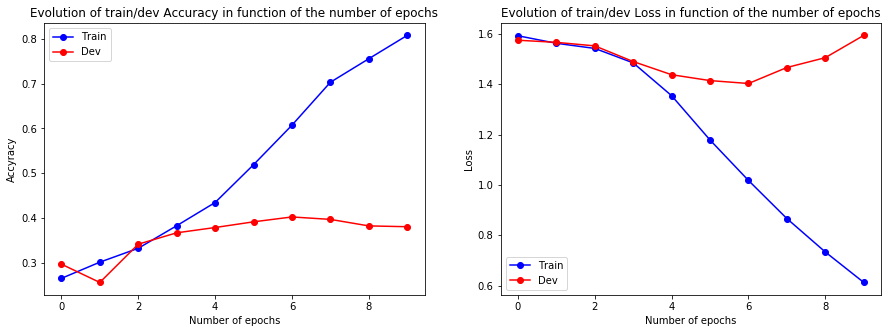

In [41]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 512
n_epochs = 10

history = model.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_val, y_val))
    
# Plot train/dev accuracy and train/dev loss
plt.figure(figsize=(15,5))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'],'bo-' , label ="Train")
plt.plot(history.history['val_acc'], 'ro-' , label = "Dev")
plt.title('Evolution of train/dev Accuracy in function of the number of epochs')
plt.ylabel("Accyracy")
plt.xlabel("Number of epochs")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],'bo-' , label ="Train")
plt.plot(history.history['val_loss'], 'ro-' , label = "Dev")
plt.title("Evolution of train/dev Loss in function of the number of epochs")
plt.ylabel("Loss")
plt.xlabel("Number of epochs")
plt.legend()

#Get the best Dev Accuracy
print('\n \nBest Dev accuracy: %s'%np.max(history.history['val_acc']))

In [42]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

y_test= model.predict(x_test)
pred=map(lambda i: str(np.argmax(y_test[i])), range(len(y_test)))
assert len(pred)==2210
np.savetxt('logreg_lstm_y_test_sst.txt', pred, fmt='%s')  

## 4.3 -- innovate !

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 49)          9057013   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          4736      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 325       
Total params: 9,086,906
Trainable params: 9,086,906
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 9s 1ms/step - loss: 1.5

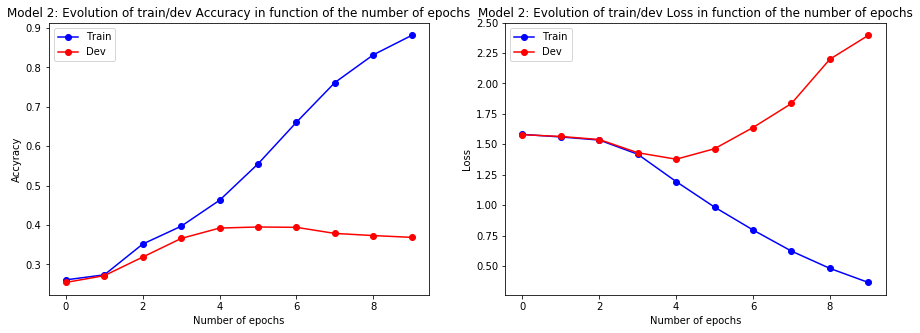

In [52]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
# create the model
bs = 512
n_epochs = 10
embed_dim  = max_len  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = vocab_size  # size of the vocabulary
n_classes  = 5

model_2 = Sequential()
model_2.add(Embedding(vocab_size, embed_dim))
model_2.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(LSTM(nhid))
model_2.add(Dense(n_classes, activation='softmax'))
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_2.summary())


history_2 = model_2.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_val, y_val))

# Plot train/dev accuracy and train/dev loss
plt.figure(figsize=(15,5))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_2.history['acc'],'bo-' , label ="Train")
plt.plot(history_2.history['val_acc'], 'ro-' , label = "Dev")
plt.title('Model 2: Evolution of train/dev Accuracy in function of the number of epochs')
plt.ylabel("Accyracy")
plt.xlabel("Number of epochs")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'],'bo-' , label ="Train")
plt.plot(history_2.history['val_loss'], 'ro-' , label = "Dev")
plt.title("Model 2: Evolution of train/dev Loss in function of the number of epochs")
plt.ylabel("Loss")
plt.xlabel("Number of epochs")
plt.legend()

#Get the best Dev Accuracy
print('\n\n Model 2: Best Dev accuracy: %s'%np.max(history_2.history['val_acc']))

#Predictions
y_test_2= model_2.predict(x_test)
pred2=map(lambda i: str(np.argmax(y_test_2[i])), range(len(y_test_2)))
np.savetxt('lstm_improved_y_test_sst.txt', pred2, fmt='%s')   

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 49, 49)            9057013   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 49, 128)           58368     
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 325       
Total params: 9,165,114
Trainable params: 9,165,114
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 32s 4ms/step - loss: 1.5845 - acc: 0.2651 - val_loss: 1.5711 - val_acc: 0.2888
Epoch 2/10
8544/8544 [==============================] - 28s 3ms/step - loss:

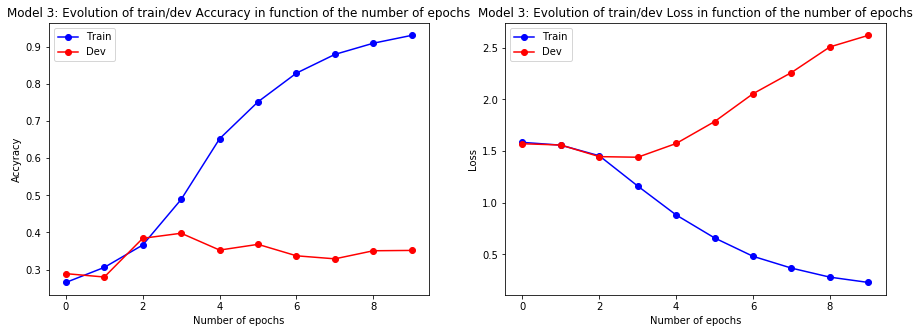

In [51]:
# Bidirectional LSTM
bs = 512
n_epochs = 10
embed_dim  = max_len  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = vocab_size  # size of the vocabulary
n_classes  = 5


model_3= Sequential()
model_3.add(Embedding(vocab_size, embed_dim,input_length=max_len)) #transform a word index into a word embedding
model_3.add(Bidirectional(LSTM(nhid,  return_sequences=True)))
model_3.add(LSTM(nhid))
model_3.add(Dense(n_classes, activation='softmax')) #classifier
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_3.summary())


history_3 = model_3.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_val, y_val))

# Plot train/dev accuracy and train/dev loss
plt.figure(figsize=(15,5))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_3.history['acc'],'bo-' , label ="Train")
plt.plot(history_3.history['val_acc'], 'ro-' , label = "Dev")
plt.title('Model 3: Evolution of train/dev Accuracy in function of the number of epochs')
plt.ylabel("Accyracy")
plt.xlabel("Number of epochs")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_3.history['loss'],'bo-' , label ="Train")
plt.plot(history_3.history['val_loss'], 'ro-' , label = "Dev")
plt.title("Model 3: Evolution of train/dev Loss in function of the number of epochs")
plt.ylabel("Loss")
plt.xlabel("Number of epochs")
plt.legend()

#Get the best Dev Accuracy
print('\n\n Model 3: Best Dev accuracy: %s'%np.max(history_3.history['val_acc']))

#Predictions
y_test_3= model_3.predict(x_test)
pred3=map(lambda i: str(np.argmax(y_test_3[i])), range(len(y_test_3)))
np.savetxt('bidirectional_lstm_improved_y_test_sst.txt', pred3, fmt='%s')   